SaltDome detectection에 관한 코드를 정리해보겠습니다.  
Salt identification challenge는 TGS라는 geoscience company에서 Kaggle에 의뢰한 competition입니다.  
해당 코드는 Dramsch라는 개발자의 제출코드를 참고하였습니다.  

Keras를 이용하였습니다.  

# before to start

실험을 진행한 스펙은 다음과 같습니다.  

- OS : Window 10 (64byte)  
- CPU : intel Core i5-6600 3,3GHz  
- GPU : NVIDIA GeForce GTX 1060 6GB


또한 주요 모듈의 버전은 다음과 같습니다.  

- CUDA 10.2
- Tensorflow 2.1.0
- Python 3.7

# Introduction

먼저, SaltDome detection은 다음 논문을 참고합니다.
- Automatic salt deposits segmentation: A deep learning approach
- Semi-Supervised Segmentation of Salt Bodies in Seismic Images using an Ensemble of Convolutional Neural Networks    

time(깊이)과 위치축에 따른 Seismic Wave Approach Map을 통해 salt dome의 위치를 파악할 수 있습니다.  

![ex_screenshot](./capture/캡쳐1.jpg)

Saltdome의 위치를 파악하는 것이 중요한 이유는, 석유 탐사에 가장 밀접한 관련이 있는 물질 중 하나이기 때문입니다.  
Saltdome은 기본 생성 환경이 바다이기 때문에, 석유가 생성되는 위치와 흡사합니다.  
Dome형태 아래에 모인 석유가 치밀한 salt 구조를 뚫고 올라오지 못해서 dome아래에 모이게 됩니다.  
또한, salt는 물에 녹기 때문에, saltdome의 존재는 해당 지역에 물이 없다는 것을 의미하기 떄문에, 경제성 높은 석유를 채굴할 수 있습니다.


따라서 지진파 데이터로 saltdome의 위치를 찾는 것은 석유 매장 위치를 알아내는데에 큰 역할을 합니다.

# experiment

아래 코드와 같이 실험을 진행해 보았습니다.


필요한 모듈을 다음과 같이 import 했습니다.  
Keras를 사용했습니다.

In [21]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

이미지 사이즈를 128 x 128로 맞추었고, 데이터 경로는 다음과 같습니다.

In [22]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/train'
path_test = 'D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/test'

5개의 이미지 예시를 다음과 같이 나타내 보았습니다.  
홀수 번째의 이미지가 실제 지진파 이미지이고, 짝수 번째의 이미지가 각 지진파 이미지에 대한 mask, 즉 label 입니다.

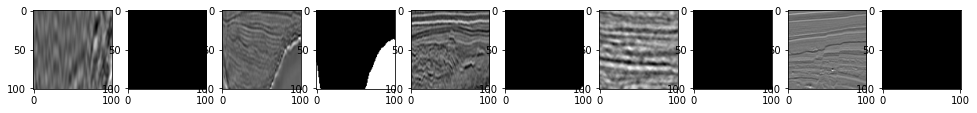

In [23]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/train/images/' + img_name + '.png')
    img_mask = load_img('D:/WONYONG/salt_area_detection/datadownload/tgs-salt-identification-challenge/train/masks/' + img_name + '.png')
     
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

train dataset과 test dataset에서 이미지들을 가져옵니다.

In [24]:
train_ids = next(os.walk(path_train+"/images"))[2]
test_ids = next(os.walk(path_test+"/images"))[2]

Train dataset의 image와 mask를 X_train이라는 데이터 셋과 Y_train이라는 데이터 셋으로 정리하고, 사이즈를 128x128x1로 맞춥니다.  
다 하면 done이라는 문구를 출력합니다.

In [25]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks')
#sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
print('Done!')

Getting and resizing train images and masks


C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Done!


X_train과 Y_train의 데이터 셋을 확인합니다.

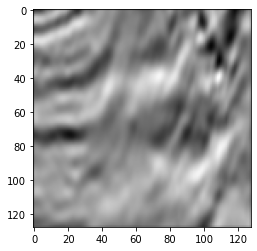

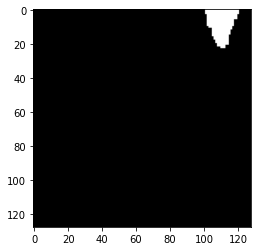

In [26]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

mean_iou라는 함수를 만듭니다.  
mean_iou는 iou (Intersection over Union) 에 대한 평균값을 말합니다.  
이것은 평가 지표로 이용된다고 볼 수 있습니다.  


입력값은 true값과 prediction값 두개입니다.  
Threshold를 0.5에서 1.0까지 0.05의 간격으로 설정하는데, 각 threshold를 넘는 것에 대해서만 참값으로 인정을 한다.   
그런데 이것이 하나의 threshold값이 아니라 0.5에서 1.0까지로 변화를 두는 이유는, 다양한 기준점이 존재하기 때문이다.

In [27]:
# Define IoU metric  
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

아래는 model architecture이다.  
optimizer는 adam이고 loss는 binary crossentropy를 사용했다.

In [28]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
____________________________________________________________________________________________

model fit을 하는데, earlystopper를 적용해서, 어느 정도의 시점에서 model fit을 정지하도록 한다.  
여기서는, 10번 동안 val_loss의 개선이 없으면 정지한다.  
또한 정확도가 0.4이상 개선되지 않으면 성능의 증가가 없다고 정의한다.  

80epoch을 돌리고, batch size는 8이다.

In [29]:
earlystopper = EarlyStopping(patience=10, verbose=0.4)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=80, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/80
3600/3600 [==============================] - 12s 3ms/step - loss: 0.5495 - accuracy: 0.7440 - val_loss: 0.4456 - val_accuracy: 0.7721

Epoch 00001: val_loss improved from inf to 0.44557, saving model to model-tgs-salt-1.h5
Epoch 2/80
3600/3600 [==============================] - 10s 3ms/step - loss: 0.5018 - accuracy: 0.7637 - val_loss: 0.3877 - val_accuracy: 0.8282

Epoch 00002: val_loss improved from 0.44557 to 0.38774, saving model to model-tgs-salt-1.h5
Epoch 3/80
3600/3600 [==============================] - 10s 3ms/step - loss: 0.3927 - accuracy: 0.8404 - val_loss: 0.3258 - val_accuracy: 0.8773

Epoch 00003: val_loss improved from 0.38774 to 0.32581, saving model to model-tgs-salt-1.h5
Epoch 4/80
3600/3600 [==============================] - 10s 3ms/step - loss: 0.3608 - accuracy: 0.8570 - val_loss: 0.2937 - val_accuracy: 0.8867

Epoch 00004: val_loss improved from 0.32581 to 0.29370, saving model to model-tgs-salt-1.h5
Epoch

Test dataset에 대해서 이미지를 정리한다.

In [30]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Done!


위에서 만든 모델 (h5로 저장된 모델) 을 load하고, test dataset을 모델에 적용해본다.

In [31]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 12s 645us/step


prediction data의 size를 일정하게 맞추고 정리한다.

In [32]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


랜덤으로 이미지를 추출해서 실제 mask 이미지와 함께 띄워본다.

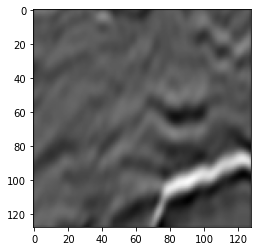

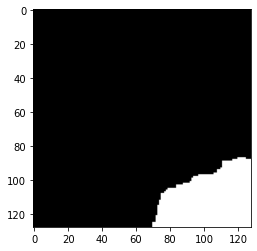

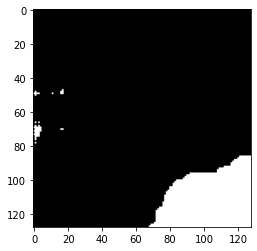

In [41]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [66]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

C:\Users\MILAB\anaconda3\envs\wonyong\lib\site-packages\ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [67]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')